<a href="https://colab.research.google.com/github/Hanbi-Kim/Git-Test/blob/main/AutoEncoder_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score

In [2]:


# 데이터 읽어오기
# 데이터 로드 (깃허브에 올려서 로드했습니다.. 만약에 코랩에서 다른 데이터 로드해서 하시려면 업로드하고 경로를 여기에 쓰시면 됩니다.)
dataset1 = pd.read_csv("https://raw.githubusercontent.com/Hanbi-Kim/Git-Test/main/health_data_with_header_2.csv")
# dataset1 = pd.read_csv('../health_data_with_header_2.csv')

dataset = dataset1[['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal', 'num']]
# 특정 필드의 값이 0인 데이터 필터링
dataset_zero = dataset[dataset['num'] == 0]

# 특정 필드의 값이 1인 데이터 필터링
dataset_one = dataset[dataset['num'] == 1]

'''
# 결과 확인 (옵션)
print("\n num 필드 값이 0인 데이터셋:")
print(dataset_zero.head())
print("\n num 필드 값이 1인 데이터셋:")
print(dataset_one.head())
'''
np.random.seed(42)  # 시드 고정

def augment_data(data, num_augmented_samples, noise_scale=0.03):
    """
    데이터에 잡음을 추가하여 데이터 증강을 수행하는 함수.

    :data: 원본 데이터 세트 (샘플, 특성)
    :num_augmented_samples: 생성할 증강된 샘플의 수
    :noise_scale: 잡음의 스케일 (표준 편차)

    :return: 증강된 데이터 세트
    """
    augmented_data = []
    for _ in range(num_augmented_samples):
        # 원본 데이터에서 무작위 샘플 선택
        sample_index = np.random.randint(0, data.shape[0])
        sample = data[sample_index]

        # 선택된 샘플에 가우시안 잡음 추가
        noise = np.abs(np.random.normal(loc=0.0, scale=noise_scale, size=sample.shape))
        augmented_sample = sample + noise

        # 증강된 샘플을 리스트에 추가
        augmented_data.append(augmented_sample)

    # 증강된 데이터를 numpy 배열로 변환
    augmented_data = np.array(augmented_data)
    return np.vstack((data, augmented_data))  # 원본 데이터와 증강된 데이터 결합

X_zero = dataset_zero.iloc[:, :-1].values
X_one = dataset_one.iloc[:, :-1].values

# 데이터 증강 실행
AX_zero = augment_data(X_zero, num_augmented_samples=500)  # 정상인경우
print(f"원본 정상 데이터 샘플 수: {X_zero.shape[0]}")
print(f"증강된 정상 데이터 샘플 수: {AX_zero.shape[0]}")

AX_one = augment_data(X_one, num_augmented_samples=500)  # 환자인경우
print(f"원본 환자 데이터 샘플 수: {X_one.shape[0]}")
print(f"증강된 환자 데이터 샘플 수: {AX_one.shape[0]}")

'''
AX_zero['target'] = 0
AX_one['target'] = 1
'''
AX_zero_df = pd.DataFrame(AX_zero, columns=['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal'])
AX_one_df = pd.DataFrame(AX_one, columns=['age', 'trestbps', 'chol', 'thalach', 'ca', 'sex', 'fbs', 'thal'])

AX_zero_df.to_csv('AX_zero_df.csv', index=False) # 정상데이터만 저장
AX_zero_df['target'] = 0
AX_one_df['target'] = 1

df = pd.concat([AX_zero_df, AX_one_df])
# new_data_set.to_csv('new_data_set.csv', index=False)
'''
# 결과 확인 (옵션)
print("데이터 필드 값이 0인 데이터셋:")
print(X_zero[:5])
print("\n데이터 필드 값이 1인 데이터셋:")
print(X_one[:5])
'''

'''
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# 필요하다면 분리된 데이터셋을 새 파일로 저장
dataset_zero.to_csv('filtered_data_zero.csv', index=False)
dataset_one.to_csv('filtered_data_one.csv', index=False)
# 학습데이터와 테스트 데이터 분리
'''

원본 정상 데이터 샘플 수: 160
증강된 정상 데이터 샘플 수: 660
원본 환자 데이터 샘플 수: 137
증강된 환자 데이터 샘플 수: 637


"\nX = dataset.iloc[:, :-1].values\ny = dataset.iloc[:, -1].values\n\n# 필요하다면 분리된 데이터셋을 새 파일로 저장\ndataset_zero.to_csv('filtered_data_zero.csv', index=False)\ndataset_one.to_csv('filtered_data_one.csv', index=False)\n# 학습데이터와 테스트 데이터 분리\n"

In [3]:
!pip install -q -U keras-tuner
import kerastuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.3 MB/s eta 0:00:00


<ipython-input-3-5d7b6944a6ac>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
# 로드된 데이터 앞 5개 확인
df.head(5)

,age,trestbps,chol,thalach,ca,sex,fbs,thal,target
0,39.0,138.0,220.0,152.0,0.0,0.0,0.0,3.0,0
1,60.0,150.0,240.0,171.0,0.0,0.0,0.0,3.0,0
2,69.0,140.0,239.0,151.0,2.0,0.0,0.0,3.0,0
3,47.0,130.0,253.0,179.0,0.0,1.0,0.0,3.0,0
4,62.0,128.0,208.0,140.0,0.0,1.0,1.0,3.0,0


In [5]:
# 불러온 데이터 기초통계량 확인
df.describe()

,age,trestbps,chol,thalach,ca,sex,fbs,thal,target
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,54.747456,132.053748,249.907568,148.776236,0.738542,0.709825,0.159973,4.860834,0.491133
std,9.170041,17.986045,51.214786,22.593707,0.972193,0.463381,0.347802,1.949454,0.500114
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,48.013616,120.008404,213.005505,132.029698,0.010477,0.031818,0.002855,3.011623,0.000000
50%,56.024153,130.012209,245.000000,152.009955,0.043451,1.003074,0.018937,3.053359,0.000000
75%,62.000000,140.040616,282.014348,165.000000,1.034612,1.021989,0.043584,7.009793,1.000000
max,77.050800,200.023781,564.015449,202.020787,3.086857,1.102269,1.061952,7.104143,1.000000


In [6]:
# num == 1인 데이터는 비정상 데이터임으로 df_abnormal에 할당
df_abnormal = df[df['target'] ==  1]

In [7]:
# num == 0인 데이터는 정상 데이터임으로 df_normal에 할당
df_normal = df[df['target'] ==  0]

In [8]:
# df_normal 데이터를 훈련과 테스트용으로 95:5 비율로 나눔
from sklearn.model_selection import train_test_split
X_train, X_test_normal, y_train, y_test = train_test_split(df_normal.drop('target',axis=1), df_normal['target'],
                                                    test_size=0.20, random_state=42)

In [9]:
# 훈련에 사용할 데이터
X_train.head(5)

,age,trestbps,chol,thalach,ca,sex,fbs,thal
18,41.000000,135.000000,203.000000,132.000000,0.000000,1.000000,0.000000,6.000000
363,51.019781,100.011594,222.010185,143.019373,0.027321,1.002756,0.056556,3.008888
597,41.019941,112.016588,250.030055,179.014927,0.023460,1.022791,0.053132,3.014146
541,42.003633,120.060203,209.008142,173.031716,0.029587,0.042557,0.025285,3.036194
61,66.000000,150.000000,226.000000,114.000000,0.000000,0.000000,0.000000,3.000000


In [10]:
# 테스트에 사용할 정상 데이터
X_test_normal.head(5)

,age,trestbps,chol,thalach,ca,sex,fbs,thal
629,49.036350,134.046454,271.008645,162.012383,0.005580,0.031818,0.054800,3.004230
499,54.009940,132.016002,288.028881,159.029430,1.029738,0.031151,1.032650,3.038381
135,34.000000,118.000000,210.000000,192.000000,0.000000,0.000000,0.000000,3.000000
480,59.007595,138.024610,271.001008,182.013642,0.015493,1.005894,0.006176,3.022397
90,44.000000,130.000000,219.000000,188.000000,0.000000,1.000000,0.000000,3.000000


In [11]:
def autoencoder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1]))

    hp_units_first = hp.Int('units', min_value = 16, max_value = 32, step = 2)
    hp_units_second = hp.Int('units', min_value = 8, max_value = 16, step = 2)
    hp_units_last = hp.Int('units', min_value = 4, max_value = 8, step = 2)

    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_last, activation = 'relu'))

    model.add(keras.layers.Dense(units = hp_units_second, activation = 'relu'))
    model.add(keras.layers.Dense(units = hp_units_first, activation = 'relu'))

    model.add(layers.Dense(X_train.shape[1], activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(),
                metrics = ['mse'])

    return model

tuner = kt.Hyperband(autoencoder,
                     objective = 'val_loss',
                     max_epochs = 5000,
                     factor = 3)

tuner.search(X_train, X_train, epochs = 10, validation_data = (X_test_normal, X_test_normal))
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 27 Complete [00h 00m 02s]
val_loss: 1131.532958984375

Best val_loss So Far: 115.98072814941406
Total elapsed time: 00h 01m 21s


In [13]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, X_train, epochs = 5000, batch_size=128,
        validation_split=0.1,
        callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min"),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-10)
    ])

# 정상 테스트 데이터의 예측 값
X_test_normal_pred = pd.DataFrame(model.predict(X_test_normal), columns=X_test_normal.columns)
X_test_abnormal = df_abnormal.drop("target", axis=1)
X_test_abnormal_pred = pd.DataFrame(model.predict(X_test_abnormal), columns=X_test_abnormal.columns)

Epoch 1/5000
4/4 [==============================] - 3s 178ms/step - loss: 11141.2373 - mse: 11141.2373 - val_loss: 7202.3350 - val_mse: 7202.3350 - lr: 0.0100
Epoch 2/5000
4/4 [==============================] - 0s 43ms/step - loss: 4845.1060 - mse: 4845.1060 - val_loss: 2140.5564 - val_mse: 2140.5564 - lr: 0.0100
Epoch 3/5000
4/4 [==============================] - 0s 35ms/step - loss: 1190.3562 - mse: 1190.3562 - val_loss: 980.7842 - val_mse: 980.7842 - lr: 0.0100
Epoch 4/5000
4/4 [==============================] - 0s 23ms/step - loss: 965.0093 - mse: 965.0093 - val_loss: 778.7925 - val_mse: 778.7925 - lr: 0.0100
Epoch 5/5000
4/4 [==============================] - 0s 24ms/step - loss: 703.8102 - mse: 703.8102 - val_loss: 686.5994 - val_mse: 686.5994 - lr: 0.0100
Epoch 6/5000
4/4 [==============================] - 0s 24ms/step - loss: 654.2669 - mse: 654.2669 - val_loss: 647.7953 - val_mse: 647.7953 - lr: 0.0100
Epoch 7/5000
4/4 [==============================] - 0s 24ms/step - loss: 61

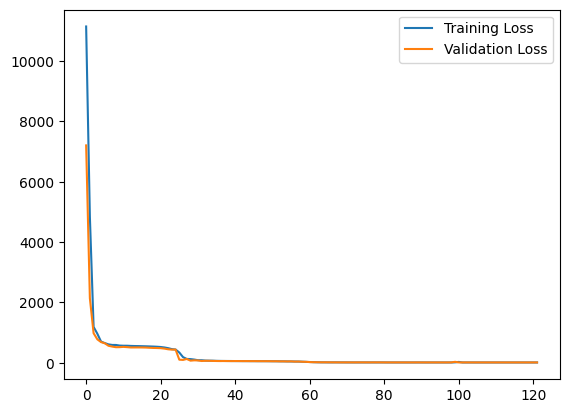

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

17/17 [==============================] - 0s 2ms/step


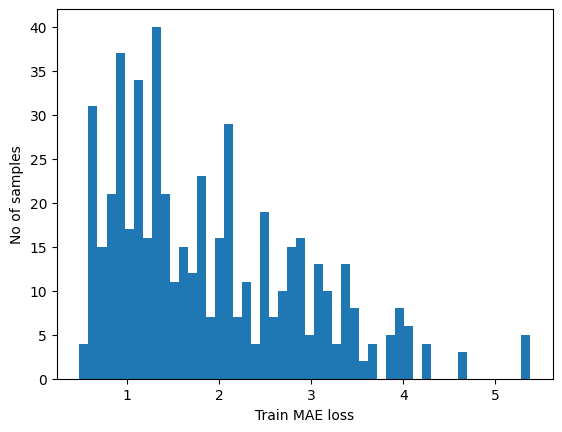

Reconstruction error max threshold:  5.380951430650029
Reconstruction error min threshold:  0.4826164245605469


In [15]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss)
print("Reconstruction error max threshold: ", np.max(train_mae_loss))
print("Reconstruction error min threshold: ", np.min(train_mae_loss))

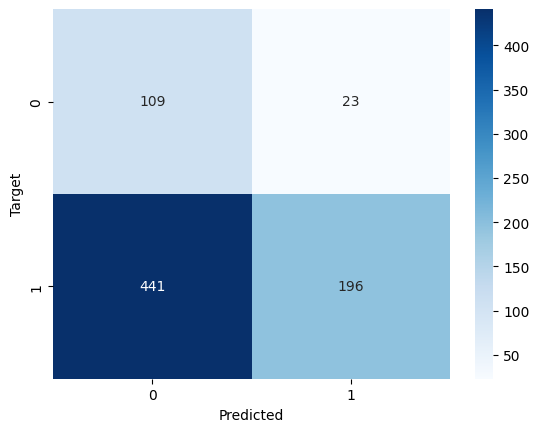

Recall-score = 0.3076923076923077
Precision-score = 0.8949771689497716
F1-score = 0.4579439252336449


In [22]:
# Threshold 조절하여 F1-score 조절가능
threshold = 3

# 비정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_abnormal['MAE'] = np.mean(np.abs(X_test_abnormal_pred - X_test_abnormal.reset_index(drop=True)), axis=1).tolist()
X_test_abnormal['Pred'] = X_test_abnormal['MAE'].apply(lambda x: 0 if x< threshold else 1)
X_test_abnormal['Target'] = 1
# 정상 테스트의 MAE를 구하고 앞서구한 threshold보다 낮다면 정상, 높다면 비정상을 Result에 저장
X_test_normal['MAE'] = np.mean(np.abs(X_test_normal_pred - X_test_normal.reset_index(drop=True)), axis=1).tolist()
X_test_normal['Pred'] = X_test_normal['MAE'].apply(lambda x: 0 if x< threshold else 1)
X_test_normal['Target'] = 0
result = pd.concat([X_test_normal,X_test_abnormal]).reset_index(drop=True)
cm = confusion_matrix(result['Target'], result['Pred'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.show()
print(f"Recall-score = {recall_score(result['Target'], result['Pred'])}")
print(f"Precision-score = {precision_score(result['Target'], result['Pred'])}")
print(f"F1-score = {f1_score(result['Target'], result['Pred'])}")